# Predicting Stock Prices using a LSTM Network

## What is a LSTM Network?
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

## Importing all needed libraries
* tqdm: for showing in a nice visual way the progress of the data management
* matplotlib: for every plot showed in the notebook
* pandas: for managing the data in a dataframe
* numpy: for math operations and for making the arrays the LSTM takes as input
* scikitlearn: for scaling the data, splitting the dataset and get the LSTM error
* keras: for the actual LSTM model
* pickle: for saving the best model 


In [1]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
# import talos as ta

from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  
Using TensorFlow backend.


# Create all base functions
* print_time: is useful when showing the time it took for the program to do something
* trim_dataset: due to the use of timeseries we need to have data that matches the time_series. This function trims the dataset so it fits the time series.
* build_timeseries: Build the time series for the input dataset

In [0]:
def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")


def trim_dataset(mat,batch_size):

    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat


def build_timeseries(mat, y_col_index):

    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


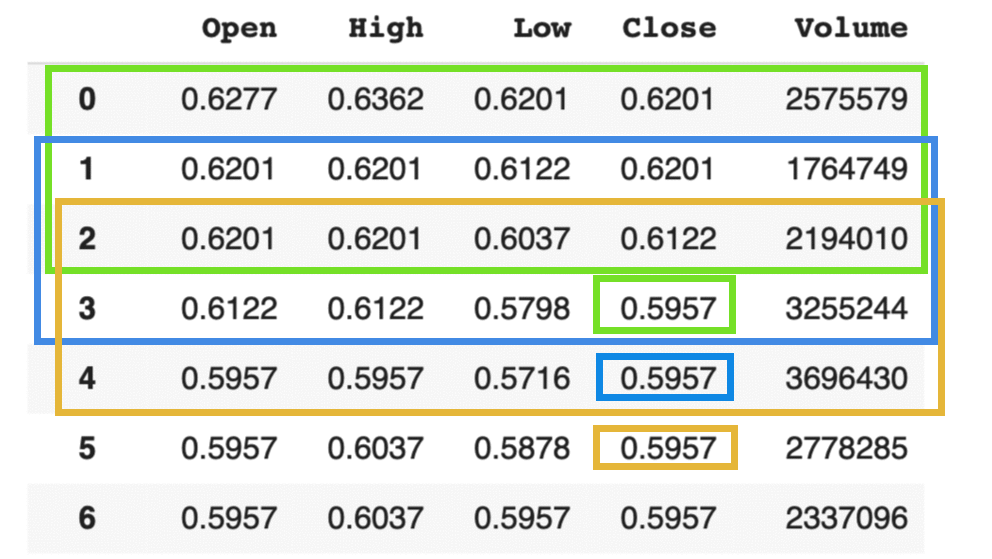

# Set the environment variables

In [0]:
iter_changes = "lstm"

PATH_TO_DRIVE_ML_DATA = "/content/drive/My Drive/Proyecto Elements"
INPUT_PATH = PATH_TO_DRIVE_ML_DATA
OUTPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/outputs/"+iter_changes


stime = time.time()

## Create the folder structure to save the best model

In [4]:
# check if directory already exists
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    print("Directory created", OUTPUT_PATH)
else:
    print("Directory already exists. Don't override.")

Directory already exists. Don't override.


# Read the dataset

In [5]:
stime = time.time()
#print(os.listdir("contents"))
df = pd.read_csv(INPUT_PATH + "/tsla.us.txt")
print(df.dtypes)
print("Shape: ", df.shape)

Date        object
Open       float64
High       float64
Low        float64
Close      float64
Volume       int64
OpenInt      int64
dtype: object
Shape:  (1858, 7)


In [6]:
print(df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')


In [7]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2010-06-28,17.00,17.00,17.00,17.00,0,0
1,2010-06-29,19.00,25.00,17.54,23.89,18783276,0
2,2010-06-30,25.79,30.42,23.30,23.83,17194394,0
3,2010-07-01,25.00,25.92,20.27,21.96,8229863,0
4,2010-07-02,23.00,23.10,18.71,19.20,5141807,0


In [8]:
df.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
1853,2017-11-06,307.00,307.50,299.01,302.78,6482486,0
1854,2017-11-07,301.02,306.50,300.03,306.05,5286320,0
1855,2017-11-08,305.50,306.89,301.30,304.31,4725510,0
1856,2017-11-09,302.50,304.46,296.30,302.99,5440335,0
1857,2017-11-10,302.50,308.36,301.85,302.99,4621912,0


As we can see the dataset contains the stock prices from tesla from 2010 to 2017. The columns that the dataset has contains the fluctations from the prices during the day. Including: 
* Open price: which is the price the stock had at the start of the day. 
* Close price: which is the price the stock had at the end of the day:
* High price: which is the highest price the stock had during the day.
* Low price: which is the lowest price the stock had during the day.
* Volume: which is the number of stocks that were traded during the day.

### Checking for NA values

In [9]:
df.isna().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

## Plotting the data 

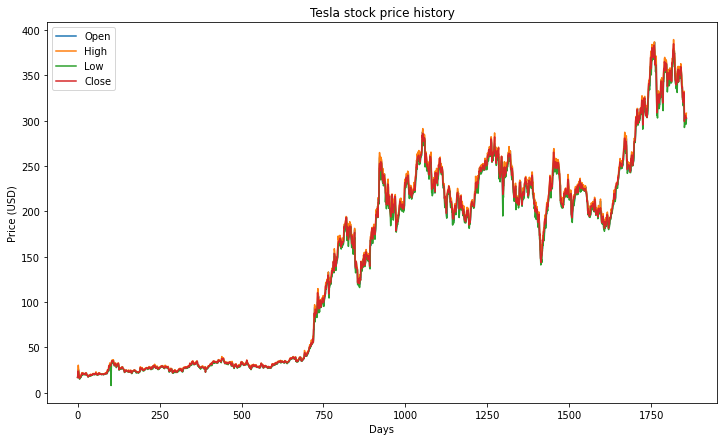

In [10]:
plt.figure(figsize=(12,7))
plt.plot(df["Open"])
plt.plot(df["High"])
plt.plot(df["Low"])
plt.plot(df["Close"])
plt.title('Tesla stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

As we can see there is little fluctuation in the prices during the day. Except for a few days where the price dropped but the price recovered the next day

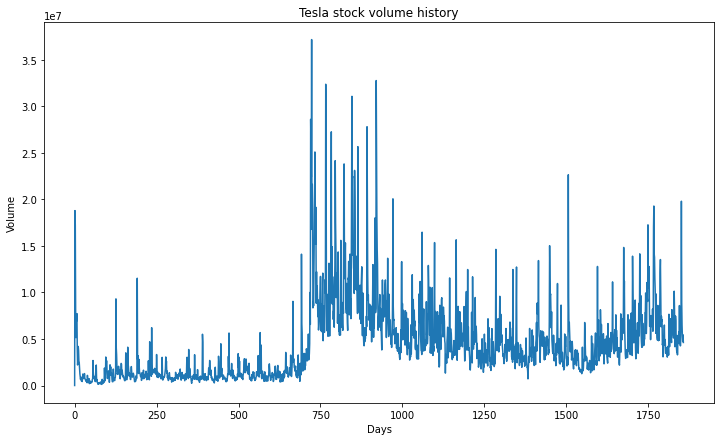

In [11]:
plt.figure(figsize=(12,7))
plt.plot(df["Volume"])
plt.title('Tesla stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

It is interesting to see that the volume of sales of the day went up almost as the same time as the price of the stocks did. 

## Split the dataset into test and training set
Distribution will be an 80% of the dataset for the training and a 20% of the data will be used for testing

In [12]:
tqdm_notebook.pandas('Processing...')


train_cols = ["Open","High","Low","Close"]
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))

Train--Test size 1486 372


## Convert and scale dataset into something to use in the LSTM


In [0]:
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

# Create the LSTM model

In [0]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model


In [0]:
def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

    return lstm_model

## Define the constant parameters to use in the model

In [0]:
params = {
    "batch_size": 2,  # 20<16<10, 25 was a bust
    "epochs": 50,
    "lr": 0.0001,
    "time_steps": 3
}

In [0]:
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

# Convert the dataset into Time Series 

### Trim the dataset so it fits the time series

In [19]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)

dim_0 1483



length of time-series i/o (1483, 3, 4) (1483,)
Batch trimmed size (1482, 3, 4) (1482,)


### Build the time series using the dataset

In [20]:
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

dim_0 369



length of time-series i/o (369, 3, 4) (369,)
Test size (184, 3, 4) (184,) (184, 3, 4) (184,)


## Look for an existing saved model and loaded it if possible

In [21]:
model = None
try:
    model = pickle.load(open("lstm_model", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")

Model not found


# Update the last saved model

In [22]:
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
    #print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    
    history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
    print("saving model...")
    pickle.dump(model, open("lstm_model", "wb"))

Building model...
Train on 1482 samples, validate on 184 samples
Epoch 1/50
 - 3s - loss: 0.0323 - val_loss: 0.0043

Epoch 00001: val_loss improved from inf to 0.00426, saving model to /content/drive/My Drive/Proyecto Elements/outputs/lstm/best_model.h5
Epoch 2/50
 - 2s - loss: 0.0277 - val_loss: 0.0039

Epoch 00002: val_loss improved from 0.00426 to 0.00391, saving model to /content/drive/My Drive/Proyecto Elements/outputs/lstm/best_model.h5
Epoch 3/50
 - 2s - loss: 0.0168 - val_loss: 0.0037

Epoch 00003: val_loss improved from 0.00391 to 0.00367, saving model to /content/drive/My Drive/Proyecto Elements/outputs/lstm/best_model.h5
Epoch 4/50
 - 2s - loss: 0.0125 - val_loss: 0.0035

Epoch 00004: val_loss improved from 0.00367 to 0.00352, saving model to /content/drive/My Drive/Proyecto Elements/outputs/lstm/best_model.h5
Epoch 5/50
 - 2s - loss: 0.0105 - val_loss: 0.0038

Epoch 00005: val_loss did not improve from 0.00352
Epoch 6/50
 - 2s - loss: 0.0092 - val_loss: 0.0040

Epoch 00006:

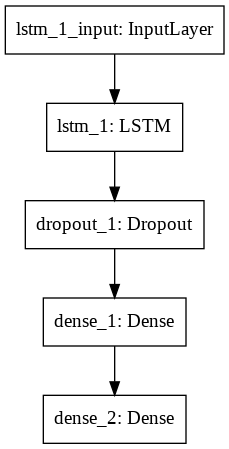

In [23]:
keras.utils.plot_model(
    model,    
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

## LSTM Layer
It is the Long Short-Term Memory Layer. It makes sure that the network "remembers" old inputs.

## Dropout Layer
Ignores some the neurons in the layer. It is useful for regularization

## Dense Layer
Common full-prop layer

# Visualize the training data

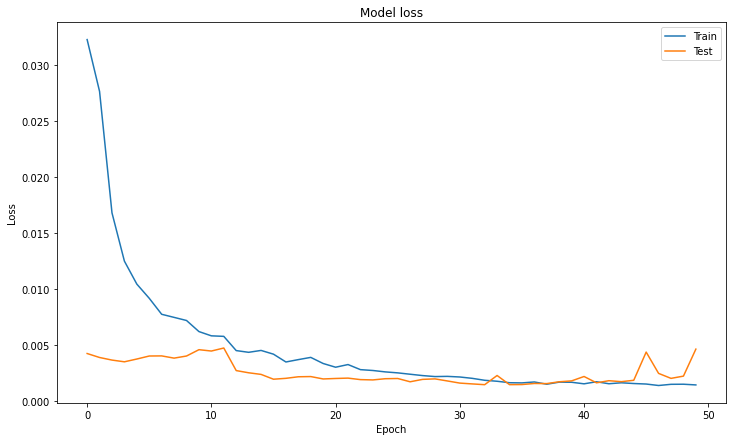

In [24]:
plt.figure(figsize=(12,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

# Load the saved best model

In [25]:
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)

# Make a prediction 

In [26]:
y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is:", error, y_pred.shape, y_test_t.shape)
print("Accuracy is:", (100 - error), y_pred.shape, y_test_t.shape)
#print(y_pred[0:15])
#print(y_test_t[0:15])

Error is: 0.05366616025374168 (184,) (184,)
Accuracy is: 99.94633383974626 (184,) (184,)


## Convert the prediction into real numbers instead of the scaled values

In [27]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])
error = mean_squared_error(y_test_t_org, y_pred_org)
print("Error is:", error, y_pred.shape, y_test_t.shape)
print("Accuracy is:", (100 - error), y_pred.shape, y_test_t.shape)

[210.58228 210.28508 254.02036 253.62819 263.72845 260.65143 246.43282
 242.61131 229.09459 230.2558  242.89215 244.43811 258.78067 258.0129
 259.61053]
[277.39 273.51 255.99 257.   246.23 249.99 250.02 250.48 251.57 251.21
 248.59 246.83 244.9  243.69 246.17]
Error is: 3919.223388460379 (184,) (184,)
Accuracy is: -3819.223388460379 (184,) (184,)


# Visualize the prediction

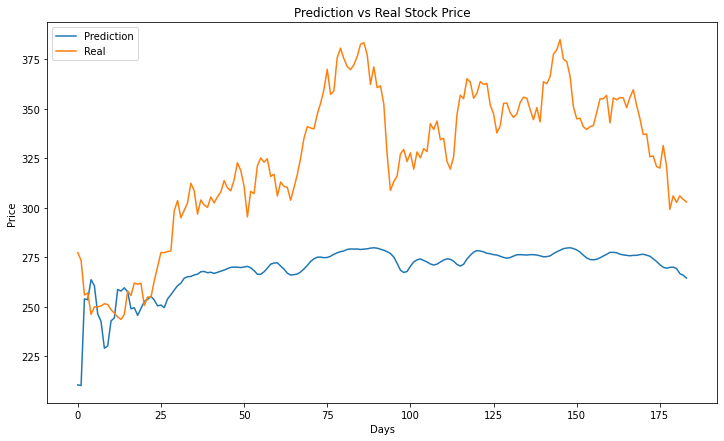

program completed  2.0 minutes :  46.0 seconds


In [29]:
plt.figure(figsize=(12,7))
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

print_time("program completed ", stime)

# Test Amazon when traning with Tesla

In [0]:
stime = time.time()
#print(os.listdir("contents"))
df = pd.read_csv(INPUT_PATH + "/amzn.us.txt")
print(df.dtypes)
print("Shape: ", df.shape)

Date        object
Open       float64
High       float64
Low        float64
Close      float64
Volume       int64
OpenInt      int64
dtype: object
Shape:  (5153, 7)


# Plotting Amazon Data

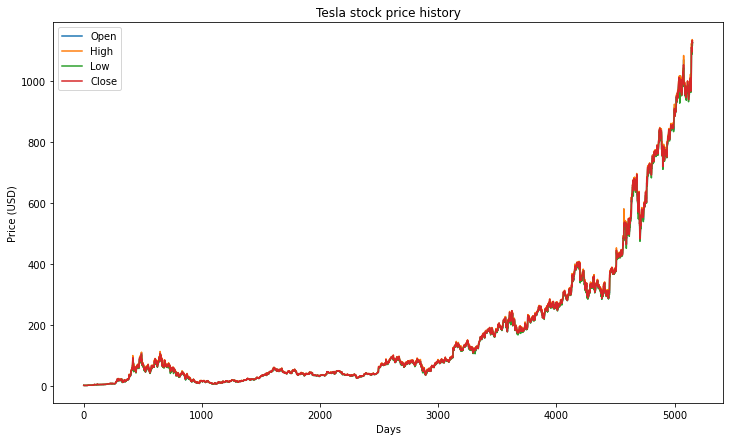

In [0]:
plt.figure(figsize=(12,7))
plt.plot(df["Open"])
plt.plot(df["High"])
plt.plot(df["Low"])
plt.plot(df["Close"])
plt.title('Tesla stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

## Split data

In [0]:
tqdm_notebook.pandas('Processing...')


train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))

Train--Test size 4122 1031


In [0]:
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

In [0]:
params = {
    "batch_size": 2,  # 20<16<10, 25 was a bust
    "epochs": 100,
    "lr": 0.0001,
    "time_steps": 3
}

In [0]:
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

## Trim

In [0]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)

dim_0 4119



length of time-series i/o (4119, 3, 5) (4119,)
Batch trimmed size (4118, 3, 5) (4118,)


## Build time series

In [0]:
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

dim_0 1028



length of time-series i/o (1028, 3, 5) (1028,)
Test size (514, 3, 5) (514,) (514, 3, 5) (514,)


## Load model

In [0]:
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)

In [0]:
y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is:", error, y_pred.shape, y_test_t.shape)
print("Accuracy is:", (100 - error), y_pred.shape, y_test_t.shape)
#print(y_pred[0:15])
#print(y_test_t[0:15])

Error is: 2.487408958009176 (514,) (514,)
Accuracy is: 97.51259104199083 (514,) (514,)


In [0]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[302.4699  302.55817 315.27563 315.30435 316.38107 316.3841  316.62518
 316.6401  316.74567 316.7629  316.78415 316.78864 316.8267  316.84546
 316.85126]
[626.55 625.9  628.35 625.31 640.95 655.65 659.37 655.49 659.68 673.25
 665.6  642.35 647.81 643.3  663.54]


program completed  0.0 minutes :  20.0 seconds


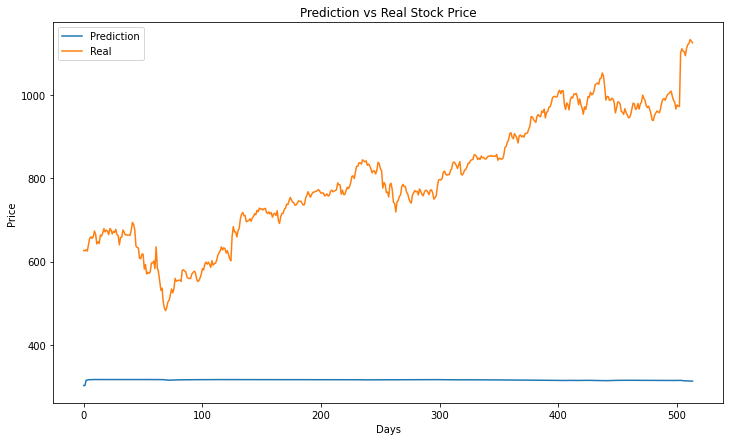

In [0]:
# Visualize the prediction

plt.figure(figsize=(12,7))
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
print_time("program completed ", stime)